### Import Python module

In [1]:
import gc
import time
import os
import cv2
import shutil
import random
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
from torch import optim
from sklearn.metrics import *
from sklearn.model_selection import KFold

seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

num_workers = 4
batch_size = 16
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
categories = ['COVID19', 'NORMAL', 'PNEUMONIA']
num_classes = len(categories)
splits = ['train', 'val', 'test']
DATA_PATH = r"C:\Gunther\Datasets\Covid19DLH_80_10_10\Data"
model_path = r"C:\Gunther\OneDrive - University of Illinois - Urbana\Python\DLH\Project"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are using {device}')

You are using cuda


### Data pre-processing (Augmentation + DataLoader)

In [3]:
transform = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                               ])
train_data = datasets.ImageFolder(root=DATA_PATH + '/train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_data = datasets.ImageFolder(root=DATA_PATH + '/val', transform=transform)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_data = datasets.ImageFolder(root=DATA_PATH + '/test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
dataset = torch.utils.data.ConcatDataset([train_data, val_data, test_data])

### Explore dataset distribution among train, validation and test

In [4]:
def show_dataset(data_path=DATA_PATH):
    df = pd.DataFrame(columns = ['code'] + splits, index = categories)
    for row in categories:
        for col in splits:
            df.loc[row,col] = int(len(os.listdir(os.path.join(data_path, col+'/'+row))))
    df['total'] = df.sum(axis=1).astype(int)
    df.loc['TOTAL'] = df.sum(axis=0).astype(int)
    df['code'] = ['0', '1', '2','']
    print(df)
    return df

df_dataset = show_dataset()

          code train  val test  total
COVID19      0   460   58   58    576
NORMAL       1  1266  158  159   1583
PNEUMONIA    2  3418  427  428   4273
TOTAL           5144  643  645   6432


### Modules to calculate metrics and confusion matrix

In [5]:
def calc_metrics(predictions, actuals, row):
    df = pd.DataFrame(columns =metrics)
    Y_pred = np.concatenate(predictions, axis=0)
    Y_test = np.concatenate(actuals, axis=0)
    df.loc[row, 'Accuracy'] = accuracy_score(Y_test, Y_pred)
    df.loc[row, 'Precision'] = precision_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'Recall'] = recall_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'F1-score'] = f1_score(Y_test, Y_pred, average="macro")
    return df

def create_confusion_matrix(preds, y_test):
    ylist, predlist = [], []
    for pred in preds:
        for item in pred:
            predlist.append(int(item))
    for y in y_test:
        for item in y:
            ylist.append(int(item))
    data_dict = {'y_Actual':    ylist, 'y_Predicted': predlist}
    df = pd.DataFrame(data_dict, columns=['y_Actual','y_Predicted'])
    cm = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['ACTUAL'], colnames=['PREDICTED'])
    return cm

def train_val_model(model):
    t_start = time.time()
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train', 'val', 'test acc'])
    print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and {n_epochs} epochs, and validating with {df_dataset.loc['TOTAL', 'val']} samples\n")
    train_size, val_size = len(train_loader), len(val_loader)
    for epoch in range(1, n_epochs+1):
        # Beginning of training step
        t0 = time.time()
        model.train()
        train_loss, val_loss = 0.0, 0.0
        for i, (data, target) in enumerate(train_loader):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()
        # Beginning of evaluation step
        model.eval()
        for j, (data, target) in enumerate(val_loader):
            target = target.to(device)
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.detach().cpu().numpy()
        predictions, actuals = calc_pred_actuals(model, test_loader)
        df_test = calc_metrics(predictions, actuals, 'Test accuracy').astype(float)
        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t val loss={val_loss/val_size:.5f} \t test acc={df_test.iloc[0,0]:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size, val_loss/val_size, df_test.iloc[0,0]]
        if use_scheduler: scheduler.step(val_loss/val_size)   # Optional to use scheduler for dynamic learning rate
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

def calc_pred_actuals(model, loader):
    predictions, actuals = [], []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            pred = model(data)
            pred = torch.argmax(pred, axis=1).cpu().numpy().reshape(-1, 1).astype('int8')
            target = target.cpu().numpy().reshape(-1, 1).astype('int8')
            predictions.append(pred)
            actuals.append(target)
    return predictions, actuals

def test_model(model, loader):
    model.eval()
    print(f"Testing the model {model_name} with {df_dataset.loc['TOTAL', 'test']} samples \n")   
    predictions, actuals = calc_pred_actuals(model, loader)
    conf_matrix = create_confusion_matrix(predictions, actuals)
    df_test = calc_metrics(predictions, actuals, 'Test Results').astype(float)
    print(df_test)
    return df_test, conf_matrix

def plot_train_val_losses(df):
    df2 = pd.melt(df, id_vars=['epoch'], value_vars=['train', 'val'], var_name='process', value_name='loss')
    sns.lineplot(x = "epoch", y = "loss", data = df2, hue = "process",
                style = "process", palette = "hot", dashes = False, 
                markers = ["o", "<"],  legend="brief").set_title("Train and Validation Losses by Epoch")
    plt.show()

### Architecture of the model

In [6]:
w = [128, 128, 256, 256]

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, w[0], 3, padding=1)
        self.bn1 = nn.BatchNorm2d(w[0])
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(w[0], w[1], 3, padding=1)
        self.bn2 = nn.BatchNorm2d(w[1])
        self.conv3 = nn.Conv2d(w[1], w[2], 3, padding=1)
        self.bn3 = nn.BatchNorm2d(w[2])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear1 = nn.Linear(14 * 14 * w[2], w[3])
        self.linear2 = nn.Linear(w[3], 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool2(self.relu(self.bn3(self.conv3(x))))
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

### Load the best model #5 saved

In [7]:
model_name = 'DLH_team'
our_model = Net().to(device)  
our_model.load_state_dict(torch.load(os.path.join(model_path, 'best5.pth')))  
_ = our_model.eval()

### Test the model loaded and show metrics

In [8]:
test_results, conf_matrix_test = test_model(our_model, test_loader)

Testing the model DLH_team with 645 samples 

              Accuracy  Precision    Recall  F1-score
Test Results  0.967442   0.967712  0.946945  0.956911


### Show confusion matrix

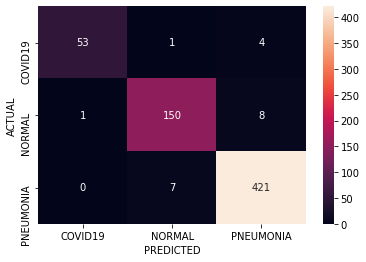

In [9]:
_ = sns.heatmap(conf_matrix_test, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

### Function to make a diagnostic

In [10]:
from PIL import Image
def diagnostic(path, model):
    model.eval()
    try:
        with torch.no_grad():
            img = Image.open(path)
            img = img.convert('RGB')
            img = transform(img)
            img = img.unsqueeze(0)
            pred = model(img.to(device))
            pred = torch.argmax(pred).cpu().numpy()
            return categories[pred]
    except:
        pass   

### Create a list with all errors from test results

In [18]:
path = r'C:\Gunther\Datasets\Covid19DLH_80_10_10\Data\test'
acc, iscorrect = [], []
for root, dirs, files in os.walk(path):
    for file in files:
        path = os.path.join(root, file)
        a = diagnostic(path, our_model)
        result = (a == file.split('(')[0])
        acc.append(result)
        iscorrect.append((result, a, file.split('(')[0], file, os.path.join(root, file)))
print(f'Accuracy: {round(sum(acc)/len(acc), 5)}')
df = pd.DataFrame(iscorrect, columns =['iscorrect', 'prediction', 'actual', 'file', 'path'])
errors = df.loc[df.iscorrect == False, ['prediction', 'path']]
errors = list(zip(errors.path.tolist(), errors.prediction.tolist()))
df.loc[df.iscorrect == False, ['prediction', 'file']]

Accuracy: 0.96744


,prediction,file
15,NORMAL,COVID19(490).jpg
26,PNEUMONIA,COVID19(515).jpg
38,PNEUMONIA,COVID19(539).jpg
47,PNEUMONIA,COVID19(552).jpg
50,PNEUMONIA,COVID19(557).jpg
84,PNEUMONIA,NORMAL(1321).jpg
86,COVID19,NORMAL(1324).jpg
161,PNEUMONIA,NORMAL(1463).jpg
169,PNEUMONIA,NORMAL(1483).jpg
206,PNEUMONIA,NORMAL(1562).jpg


### Project all errors from the test results

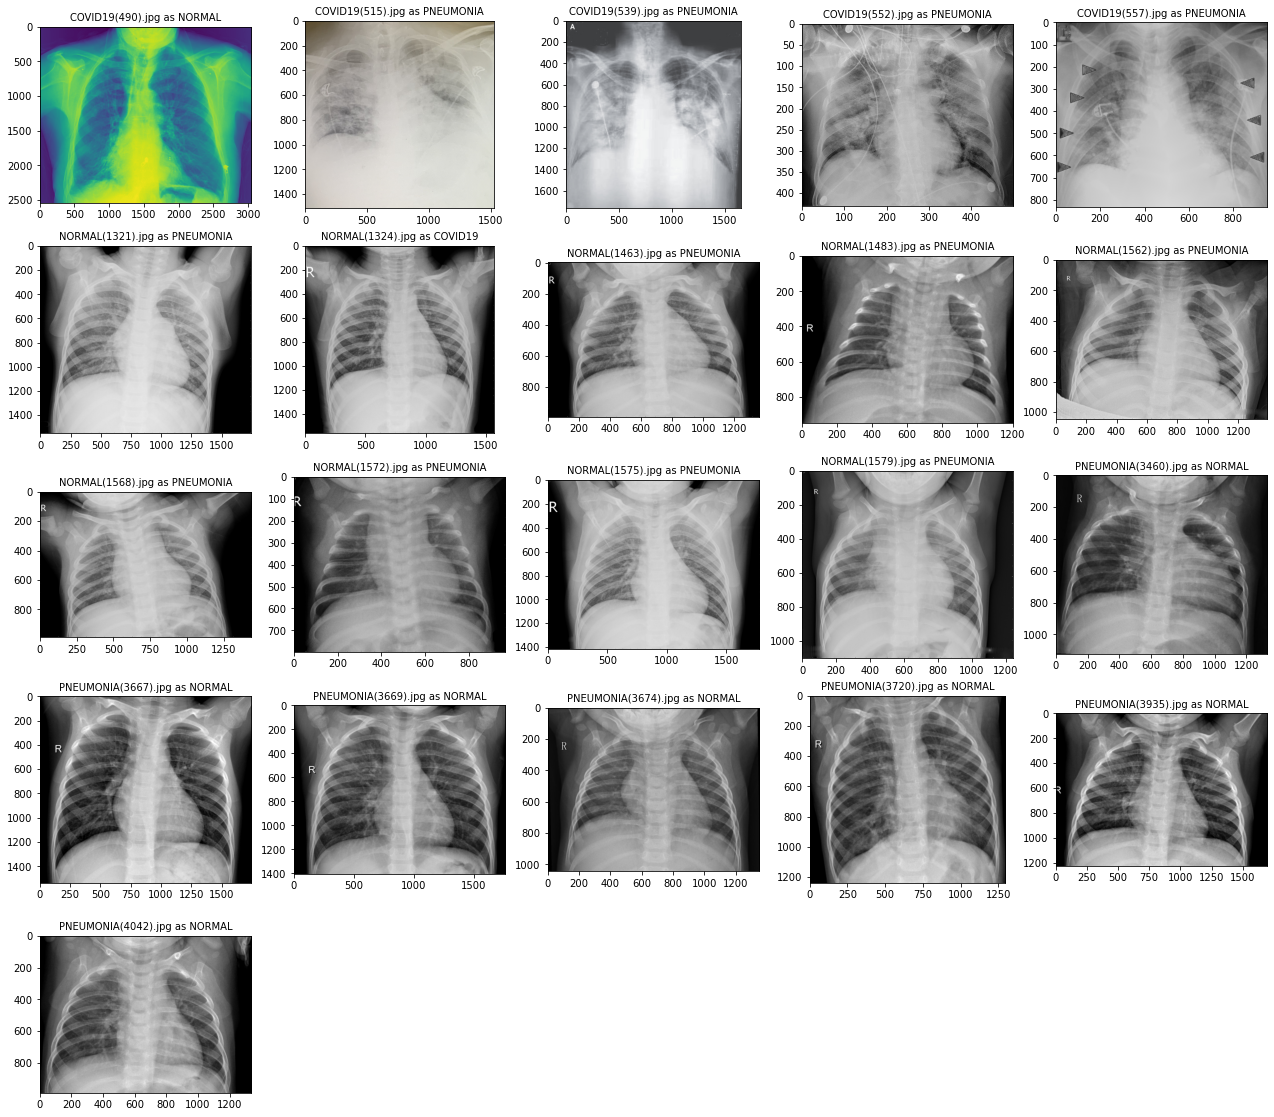

In [31]:
from PIL.Image import Image as PilImage
import textwrap, os

def display_images(
    images: [PilImage], 
    columns=5, width=22, height=5, max_images=100, 
    label_wrap_length=50, label_font_size=10):
    if not images:
        print("No images to display.")
        return 
    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]
    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, (image, label) in enumerate(images):
        image = Image.open(image)
        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)
        if hasattr(image, 'filename'):
            title=image.filename
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title) + " as " + label
            plt.title(title, fontsize=label_font_size);

display_images(errors)